<a href="https://colab.research.google.com/github/t6nand/mloptimization/blob/master/stochastic_subgradient_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initial setup to enable use of latex with matplotlib. Comment after first use.

In [0]:
# ! sudo apt-get install texlive-latex-recommended #1
# ! sudo apt-get install dvipng texlive-fonts-recommended #2
# ! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip #3
# ! unzip type1cm.zip -d /tmp/type1cm #4
# ! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins  #5
# ! sudo mkdir /usr/share/texmf/tex/latex/type1cm #6
# ! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm #7
# ! sudo texhash #8

Import packages and initialize plot formatting

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import csv # For importing CSV data as python datastructure

plt.rcParams['font.size'] = 7
plt.rcParams['lines.markersize'] = 4
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 150

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

Import Features and corresponding labels from the provided CSV files. Features here are the total and tail energies of the waveforms produced by a nuclear particle detector.

In [0]:
# Load training data
Features = np.loadtxt('nuclear_x.csv', delimiter=',', skiprows=1)

# Load output labels for the training samples.
Labels = np.loadtxt('nuclear_y.csv', delimiter=',', skiprows=1)

Initialization of required constants and functions.

For the given hinge loss functions as below:
\begin{equation}
J(w,b) = \frac{1}{n}\sum_{i=1}^{n}L(y_i, <w, x_i> + b) + \frac{\lambda}{2}\|w\|_2^2
\end{equation}

The subgradient for each $J_i$ w.r.t $\theta = [b\,\,w^T]^T$ is given as below:
\begin{equation}
u_i(\theta) = \frac{1}{n}(\lambda \widetilde{w} + 
\begin{cases}
-y_i\widetilde{x_i}& \text{if}\ y_i\widetilde{x_i}^T\theta \leq 1 \\
0 & \text{otherwise}
\end{cases}
)
\end{equation}

Thus subgradient of $J$ becomes $subgradient(J) = \sum_{i=1}^{n}u_i(\theta)$

In [0]:
lamda = 0.001 # Regularizer 
step_sizes = lambda i: 100/i # decaying step size per epoch

# Function to calculate subgradient of batch of samples.
def subgradient_batch(X, y, w, b):
    loss_mask = (((X @ w + b) * y) <= 1)
    dw = -(y[loss_mask, None] * X[loss_mask, :]).sum(0)
    db = -y[loss_mask].sum()
    return dw, db


# Function to implement stochasitc sub gradient method for evaluating optimum 
# parameter values.
def stochastic_sub_gradient_method(X, y, step_sizes, sample_size, lamda, num_iter=100):
    
    num_samples, dim_samples = X.shape
    w = np.zeros(dim_samples)
    b = 0
    
    ws = [w.copy()]
    bs = [b]
    
    for j in range(1, num_iter + 1):
        
        alpha = step_sizes(j)
        perm = np.random.permutation(num_samples)
        
        for k in range(0, num_samples, sample_size):
            
            indices = perm[k*sample_size:(k+1)*sample_size]
            
            dw, db = subgradient_batch(X[indices, :], y[indices], w, b)
            dw += lamda * w * len(indices)
            dw /= num_samples
            db /= num_samples
            
            w -= alpha * dw # Weight update rule
            b -= alpha * db # Bias update rule
            ws.append(w.copy())
            bs.append(b)
    
    return ws, bs

# Function that calculates loss
def evaluate_loss(X, y, ws, bs, lamda):
    
    loss = []

    for w, b in zip(ws, bs):
        hinge_loss = np.maximum(1 - ((X @ w + b) * y), 0)
        loss.append(hinge_loss.mean() + lamda / 2 * np.linalg.norm(w) ** 2)
    
    return loss

Run simulation for following cases:

1. The whole training data is used as a batch. Hence, sub gradient is not stochastic.
2. A sample is chosen from training data at random. Sample size here is kept to 1, and hence the sub gradient is a random variable. Hence it is $\#number\,of\,samples$ time faster than the previous case.

The parameters and loss are computed for the both cases using functions described above.


In [0]:
# SGM: Gradients are not stochastic. Whole training data is used to compute sub gradient. Hence, it's deterministic
w_hat, b_hat = stochastic_sub_gradient_method(Features, Labels, step_sizes, Features.shape[0], lamda, 100)
loss = evaluate_loss(Features, Labels, w_hat, b_hat, lamda)

# Stochastic case: Sample batch is chose at random per epoch and sub gradient is thus random. 
sto_w_hat, sto_b_hat = stochastic_sub_gradient_method(Features, Labels, step_sizes, 1, lamda, 100)
sto_spaing = 100 # Evaluate loss per 100 iterations as it's expensive
sto_loss = evaluate_loss(Features, Labels, sto_w_hat[::sto_spaing], sto_b_hat[::sto_spaing], lamda)

Plot the decision boundaries learned by the stochastic sub gradient method for both cases along with the scatter plot of the training data.

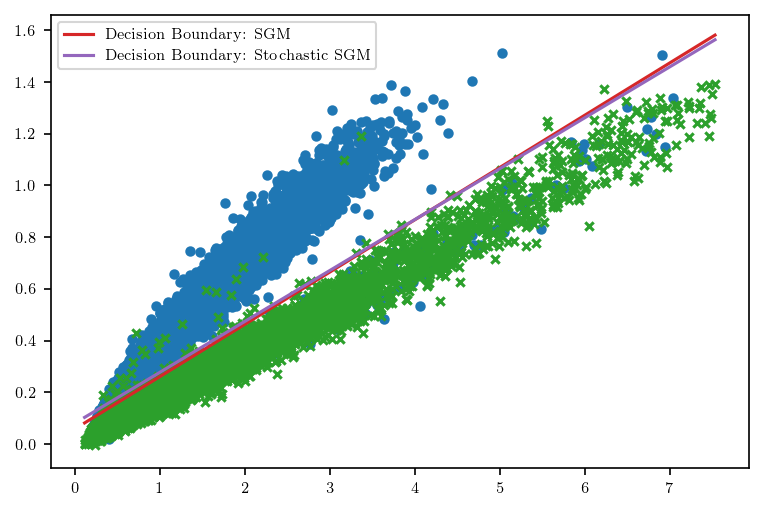

In [24]:
fig1, ax1 = plt.subplots()

# Scatter all labels belonging to class label +1
ax1.scatter(Features[Labels == 1, 0], Features[Labels == 1, 1])
# Scatter all labels belonging to class label -1
ax1.scatter(Features[Labels == -1, 0], Features[Labels == -1, 1], marker='x', facecolors=colors[2])


# Plot the decision boundary 
def plot_linear_decision_boundary(w, b, x_min, x_max, color, label, axis):
    axis.plot([x_min, x_max], [-x_min*w[0]/w[1] - b/w[1], -x_max*w[0]/w[1] - b/w[1]], color=color, label=label)

x_min, x_max = Features[:, 0].min(), Features[:, 0].max()
plot_linear_decision_boundary(w_hat[-1], b_hat[-1], x_min, x_max, colors[3], 'Decision Boundary: SGM', ax1)
plot_linear_decision_boundary(sto_w_hat[-1], sto_b_hat[-1], x_min, x_max, colors[4], 'Decision Boundary: Stochastic SGM', ax1)
plt.legend()
plt.show()

Plot the loss for the both cases w.r.t the number of iterations.

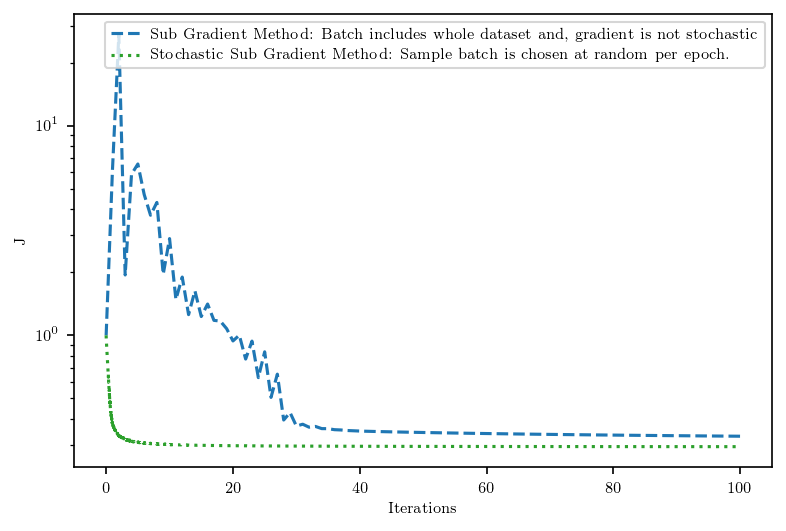

In [25]:
fig2, ax2 = plt.subplots()

ax2.plot(np.arange(len(loss)), loss, '--', label='Sub Gradient Method: Batch includes whole dataset and, gradient is not stochastic')
ax2.plot(np.arange(len(sto_loss)) / Features.shape[0] * sto_spaing, sto_loss, ':', color=colors[2], label='Stochastic Sub Gradient Method: Sample batch is chosen at random per epoch.')
plt.yscale('log')
plt.ylabel('J')
plt.xlabel('Iterations')
plt.legend()
plt.show()